In [18]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

from Utils import seed, load_data, get_train_dataloader, get_test_dataloader, mean_absolute_percentage_error, \
    model_to_log, split_x_train, load_data_phase

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# Change this flag if you want to use wandb
use_wandb = False

if use_wandb:
    import wandb

    with open('wandb_key') as key_file:
        wandb_key = key_file.readline()
    wandb.login(key=wandb_key)

seed(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def double_conv_block(in_channels: int, out_channels: int, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=0),
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=0),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


def get_model(input_dim, output_dim):
    conv_part = nn.Sequential(
        double_conv_block(input_dim[0], 16, 3),
        double_conv_block(16, 32, 3),
        double_conv_block(32, 64, 3),
        nn.Flatten())

    x = torch.unsqueeze(torch.zeros(input_dim), 0)
    size = conv_part.forward(x).size()[1]
    print('Flatten size:', size)

    model = nn.Sequential(
        conv_part,
        nn.Linear(size, 256),
        # nn.Dropout(p=0.01),
        nn.ReLU(),
        nn.Linear(256, 64),
        # nn.Dropout(p=0.01),
        nn.ReLU(),
        nn.Linear(64, output_dim)
    )

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    model.to(device)
    return model

In [20]:
def load_model(file, input_dim, output_dim):
    model = get_model(input_dim, output_dim)
    model.load_state_dict(torch.load(file)['model_state_dict'])
    model.eval()
    return model

In [21]:
def train_epoch(model, loss, optimizer, dataloader, do_train):
    running_loss = 0.

    # Iterate over data.
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # forward and backward
        with torch.set_grad_enabled(do_train):
            preds = model(inputs)
            loss_value = loss(preds, targets)

            # backward + optimize only if in training phase
            if do_train:
                loss_value.backward()
                optimizer.step()

        # statistics
        running_loss += loss_value.item()

    epoch_loss = running_loss / len(dataloader)

    return epoch_loss


def train_model(model, loss, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs, config):
    best_val_loss = math.inf
    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()  # Set model to evaluate mode

            epoch_loss = train_epoch(model, loss, optimizer, dataloader, phase == 'train')

            if phase == 'train':
                scheduler.step()

            if phase == 'train':
                train_loss = epoch_loss
            else:
                val_loss = epoch_loss

            if phase == 'val' and best_val_loss > epoch_loss:
                print('new best val loss', epoch_loss, 'epoch', epoch)
                best_val_loss = epoch_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'model_name': config['exp_name']
                }, f'{config["exp_name"]}.pth')

        if use_wandb and phase == 'val':
            wandb.log({f'train loss': train_loss, f'val loss': val_loss})

    return model

In [22]:
lr = 1e-3
epochs = 200
batch_size = 4
step_size = 20
gamma = 0.5
params = ['V']

config = {
    "lr": lr,
    "epochs": epochs,
    "bs": batch_size,
    "sched": 'StepLR',
    "sched_ss": step_size,
    "sched_g": gamma,
    "optim": 'Adam',
    "pref": 'forward',
}
important_keys = ['optim', 'bs', 'pref']
config['exp_name'] = '_'.join(map(lambda key: f'{key}={config[key]}', important_keys))
model_file_name = config['exp_name']

In [23]:
x_train, y_train = load_data_phase('Data_V_D', params, (64, 64))
mean = y_train.mean(axis=0)
dispersion = ((y_train - mean) ** 2).mean(axis=0)
y_train = (y_train - mean) / np.sqrt(dispersion)

125


In [24]:
def norm(array):
    return (array - mean) / np.sqrt(dispersion)


def denorm(array):
    return array * np.sqrt(dispersion) + mean

In [25]:
x_val, y_val = load_data_phase('Test', params, (64, 64))
y_val = norm(y_val)
x_val, y_val = map(lambda x: torch.tensor(x, dtype=torch.float, device=device), (x_val, y_val))

4


In [26]:
x_train, y_train, x_test, y_test = map(lambda x: torch.tensor(x, dtype=torch.float, device=device), split_x_train(x_train, y_train, 16))


train_dataloader = get_train_dataloader(x_train, y_train, batch_size)
test_dataloader = get_test_dataloader(x_test, y_test, batch_size)

test files [7, 10, 11, 21, 32, 39, 46, 85, 94, 103, 106, 108, 109, 110, 121, 122]


In [27]:
model = get_model(x_train[0].size(), len(params))

config['model'] = model_to_log(model)

loss_func = torch.nn.L1Loss()
# loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Flatten size: 1024
351361


In [28]:
if use_wandb:
    run = wandb.init(project='Chemistry', config=config)
    wandb.run.name = config['exp_name']

In [29]:
model = train_model(model, loss_func, optimizer, scheduler, train_dataloader, test_dataloader, epochs, config)

new best val loss 0.518353745341301 epoch 0
new best val loss 0.4341421388089657 epoch 1
new best val loss 0.4074144810438156 epoch 2
new best val loss 0.2173982635140419 epoch 3
new best val loss 0.17501406371593475 epoch 8
new best val loss 0.09402718022465706 epoch 12
new best val loss 0.07752497773617506 epoch 18
new best val loss 0.07471704855561256 epoch 26
new best val loss 0.06470715347677469 epoch 45
new best val loss 0.06395232491195202 epoch 58
new best val loss 0.05614353809505701 epoch 76


In [30]:
best_model = load_model(f'{config["exp_name"]}.pth', x_train[0].size(), len(params))

Flatten size: 1024
351361


In [31]:
y_test_result = best_model.forward(x_test).detach()
y_train_result = best_model.forward(x_train).detach()
y_val_result = best_model.forward(x_val).detach()

In [32]:
y_test_result_np = y_test_result.cpu().numpy()
y_train_result_np = y_train_result.cpu().numpy()
y_val_result_np = y_val_result.detach().cpu().numpy()

y_test_np = y_test.detach().cpu().numpy()
y_train_np = y_train.detach().cpu().numpy()
y_val_np = y_val.detach().cpu().numpy()

In [33]:
def show(i):
    sort = y_train_np[:, i].argsort(axis=0).reshape((-1,))

    fig = plt.figure(figsize=(12, 12))
    ax_train = fig.add_subplot(3, 1, 1)
    ax_train.plot(denorm(y_train_np[sort][:, i]), 'go', label='train')
    ax_train.plot(denorm(y_train_result_np[sort][:, i]), 'ro', label='result')
    ax_train.set_ylabel(params[i])
    ax_train.set_xlabel('num File')
    ax_train.legend()

    sort = y_test_np[:, i].argsort(axis=0).reshape((-1,))

    ax_test = fig.add_subplot(3, 1, 2)
    ax_test.plot(denorm(y_test_np[sort][:, i]), 'go', label='test')
    ax_test.plot(denorm(y_test_result_np[sort][:, i]), 'ro', label='result')
    ax_test.set_ylabel(params[i])
    ax_test.set_xlabel('num File')
    ax_test.legend()

    sort = y_val_np[:, i].argsort(axis=0).reshape((-1,))

    ax_test = fig.add_subplot(3, 1, 3)
    ax_test.plot(denorm(y_val_np[sort][:, i]), 'go', label='val')
    ax_test.plot(denorm(y_val_result_np[sort][:, i]), 'ro', label='result')
    ax_test.set_ylabel(params[i])
    ax_test.set_xlabel('num File')
    ax_test.legend()

    plt.show()

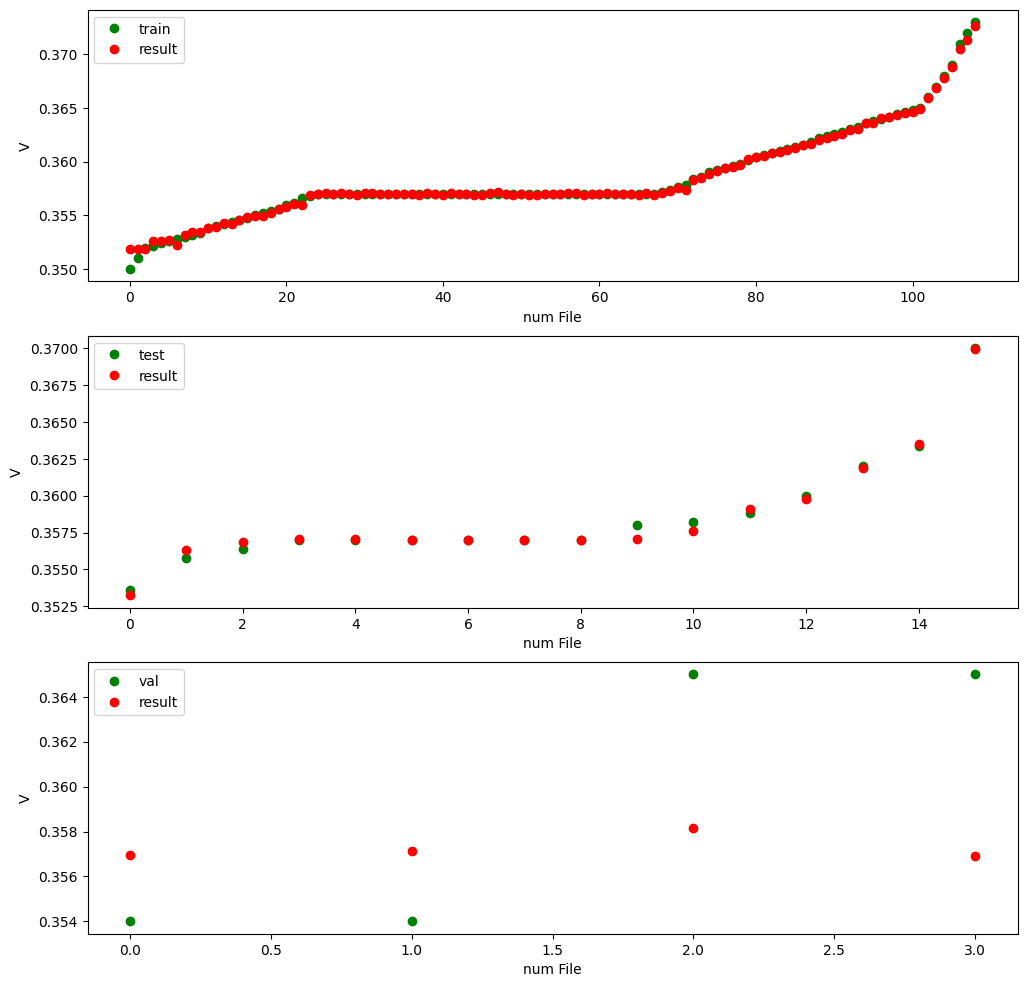

In [34]:
for i, param in enumerate(params):
    show(i)

In [35]:
def get_loss(result, real, i):
    error_p = mean_absolute_percentage_error(result[:, i], real[:, i]).item()
    error_a = loss_func(result[:, i], real[:, i]).item()
    return round(error_p, 6), round(error_a, 6)

def print_errors(i):
    train_error_p, train_error_a = get_loss(y_train_result, y_train, i)
    print('train error', train_error_a)
    test_error_p, test_error_a = get_loss(y_test_result, y_test, i)
    print('test error', test_error_a)
    val_error_p, val_error_a = get_loss(y_val_result, y_val, i)
    print('val error', val_error_a)

In [36]:
for i, param in enumerate(params):
    print(param, 'errors')
    print_errors(i)

V errors
train error 0.031856
test error 0.056144
val error 1.248768


In [37]:
if use_wandb:
    wandb.finish()